# Quantile regression in practice
https://medium.com/@qucit/a-simple-technique-to-estimate-prediction-intervals-for-any-regression-model-2dd73f630bcb

일반적으로 Gradient Boosting Regressor와 quantile regressor은 몇 가지 실질적인 단점이 있다.


극단적인 분위수로 설정을 하면, Gradient Boosting Regressor는 실제값과 매우 먼 간격을 생성하는 경향이 있다. 위의 부스팅 예시만 봐도 그렇다. Plot에서 보듯이, 이것은 분위수가 틀렸다는 것을 의미하지는 않지만,우리는 실제 데이터에 가장 가까운 정량형(Quantile)을 선호한다.

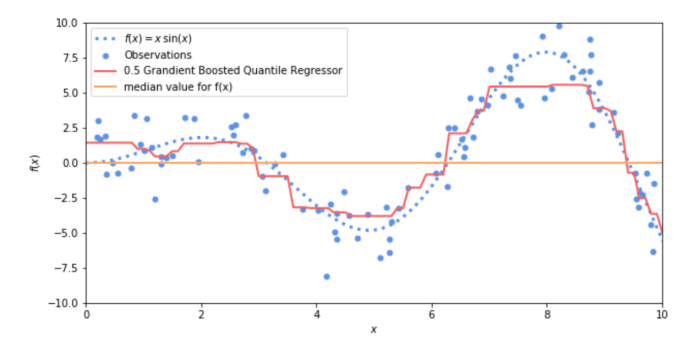

위 사진의 단순 중앙값 선(Orange)과 0.5 Quantile의 부스팅 선(Red)을 보자. 두 선 모두 실제 값을 절반으로 나누지만, 주황색 선은 쓸모가 없는 편이다.

주차 시간을 예시로 들어보자. Orage 선은 주차 소요 시간을 항상 10분으로 예측한다. 주차시간이 0에 가까운 밤이나 주차시간이 매우 커질 수 있는 아침 등, 항상 10분을 예측하는 모델은 문맥에 적응할 수 있는 모델에 비하면 전혀 쓸모가 없다.


**또 다른 단점은 각 Quantile에 자체적인 예측기가 필요하다는 것이다.** 최종 적용에 따라 정밀도의 필요성이 달라질 수 있으며 때로는 예측의 전체 분포를 추정하고자 한다. 가능한 해결책은 가능한 각 Quantile마다 모델을 훈련시키는 것이지만, 이것은 비효율적인 해결책이다. 각 백분위수(0.99까지 0.01, 0.02, 0.03 등)에 대한 추정치를 원한다고 가정해보자. 이러한 해결책은 99개 모델의 훈련과 관리를 의미한다. *반대로 전체 기초 분포를 추정할 수 있는 단일 모델을 갖는 것은 단일 모델만 교육하고 관리한다는 것을 의미한다.*

마지막으로, 모든 유형의 회귀 모형에 대해 QR을 사용할 수 있는 것은 아니다. Scikit-learn에서 이를 구현하는 유일한 모델은 Gradient Boost Regressor이다. XGBoost의 경우처럼 모델의 비용 기능을 사용자 정의하여 QR을 쓸 수 있다.

일반적으로 이것은 사용자 정의 알고리즘과 구현에 대한 깊은 이해가 필요한 복잡한 과정이다. Quitt이 제작한 Distribution Estimator를 살펴보자.

## Distribution estimator
Distribution estimator는 재훈련 및 재보정을 수행할 필요 없이 주어진 확률에 대해 QR을 계산할 수 있는 훈련된 모델이다.

확률 값(0.1, 0.2, 0.5 등)당 한개의 분위수를 기준으로 예측하는 표준 QR과는 달리, 이 추정기는 예측의 전체 분포를 예측한다. 이 접근방식은 하나의 모델을 대상별로 훈련시키는 전체 과정을 줄여 계산적으로 비용이 적게 들고 유지관리가 용이하게 한다.

### How can we predict a distribution?
Quit의 분포 추정기의 주요 가정은 원하는 예측이 정규 분포를 따른다는 것이다. 이것은 처음에는 강한 가정처럼 보이지만, 다음에 우리가 보여주듯이, 실제로 이러한 가정은 만족스러운 결과로 이어진다.


따라서 분포 추정기는 해당 예측에 대한 예측값과 추정 오차를 생성하여 작동한다. 이 두 값에서 추정 오차와 동일한 표준 편차를 가진 예측을 중심으로 한 가우스 함수로 분포를 추정한다. 즉, 모델은 가우스 분포의 평균을 예측하는 반면, 추정 오차는 분포의 표준 편차를 제공한다.


값과 오류 예측을 산출하는 두 가지 주요 전략이 있다.

#### Training a machine learning model to predict values, and using its RMSE to compute the error
첫 번째 전략은 정규 분포의 표준 편차가 일정하다고 가정한다. 첫 번째 회귀 모형인 base model은 훈련 세트로 학습이 되고, 모델에 대한 RMSE는 검증 세트로 평가되어 표준 편차에 대한 추정으로 사용된다.

아래는 샘플 코드임.

In [ ]:
# split the data into a train and validation sets
X1, X2, y1, y2 = train_test_split(X_train, Y_train, test_size=0.5)

# base_model can be any regression model
base_model = GradientBoostingRegressor(n_estimators=500, max_depth=8,
                                       learning_rate=.01, min_samples_leaf=20,
                                       min_samples_split=20)
base_model.fit(X1, y1)
base_prediction = base_model.predict(X2)

#compute the RMSE value
error = mean_squared_error(base_prediction, y2) ** 0.5

# compute the mean and standard deviation of the distribution
mean = base_model.predict(X_test) 
st_dev = error

##### 모델을 학습하여 예측값과 오류를 예측
실제로 오류는 특징에 따라 달라지기 때문에 항상 일정한 것은 아니다. 따라서, 개선방법으로 오류 자체를 학습하기 위한 모델을 만들 수 있다.

이전과 같이, 기본 모델은 train 데이터로부터 학습된다. 그런 다음 두 번째 모델(오류 모델)을 validation 세트에 대해 교육하여 예측과 실제 값 사이의 제곱 차이를 예측한다. 

분포의 표준 편차는 오차 모델에 의해 예측된 오차의 근원을 취함으로써 계산된다. 아래 코드를 참고해 보자.

In [ ]:
# split the data in train a validation set 
X1, X2, y1, y2 = train_test_split(X_train, Y_train, test_size=0.5) 
# base_model can be any regression model
# sklearn.ensemble.GradientBoostingRegressor for instance 
base_model = GradientBoostingRegressor(n_estimators=500, max_depth=8,
                                       learning_rate=.01, min_samples_leaf=20,
                                       min_samples_split=20)
error_model = GradientBoostingRegressor(n_estimators=100, max_depth=4,
                                        learning_rate=.01, min_samples_leaf=20,
                                        min_samples_split=20)

base_model.fit(X1, y1) 
base_prediction = base_model.predict(X2) 
# compute the prediction error vector on the validation set 
validation_error = (base_prediction - y2) ** 2 
error_model.fit(X2, validation_error) 
# compute the mean and standard deviation of the distribution 
mean = base_model.predict(X_test) 
st_dev = error_model.predict(X_test)**0.5

### Results

이 글에서 사용된 4가지 모델 적용은 다음과 같다고 함.
- Quantile Gradient Boosting Regressor
 - QR 그래티언트 부스팅 회귀 모델
- A fixed error Distribution Estimator based on a standard Gradient Boosted Regressor(referred as RMSE GBR Distribution Estimator)
 - validation에서 나온 rmse를 표준편차로 가정하여 test data에 Quantile을 지정하는 방법
- A Distribution Estimator composed of a Gradient Boosted Regressor base model and a Gradient Boosted Regressor error model (referred as GBR Distribution Estimator)
 -  validation에서 나온 rmse를 종속변수로 두고 새로운 그래디언트 부스팅 모델로 다시 학습해서 test 데이터에도 똑같이 적용 
- A Distribution Estimator composed of a K Nearest Neighbor base model and a K Nearest Neighbor error model (referred as KNN Distribution Estimator)
 -  validation에서 나온 rmse를 종속변수로 두고 새로운 KNN 모델로 다시 학습해서 test 데이터에도 똑같이 적용(train,error train 모두 KNN 사용) 

Distribution estimator는 QR 그레디언트 부스팅 모델보다 훈련 및 사용 할때 자원이 덜 든다(only two models instead of one per quantile). 심지어, 표준 QR보다 더 좁은 예측구간을 만들어 내는 경향이 있다. 다음 그림은 기본 모델과 오류 모델이 두 개의 그라데이션 부스팅 Regressor(3 번째 정의 모델)인 분포 추정기에 의해 추정된 90% 예측 구간을 보여준다.

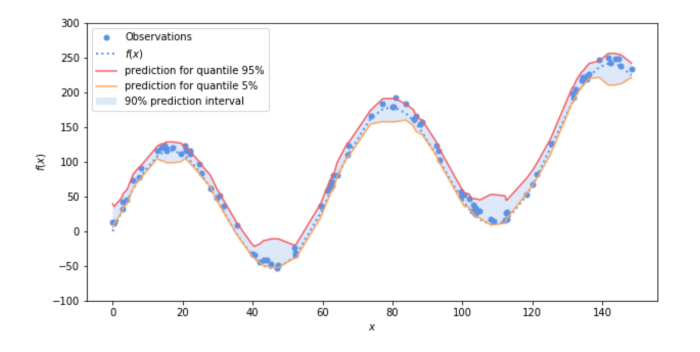

Distribution estimator의 또 다른 장점은 어떤 기계 학습 모델로도 그것들을 구축할 수 있다는 것이다. 아래 그림에서 볼 수 있듯이 KNN 모델을 기반으로 한 distribution estimator는 상당히 놀라운 좋은 결과를 만들어 낸다.

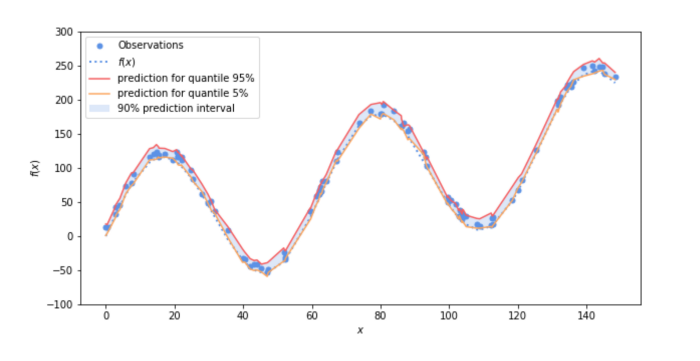

여러개의 모델을 비교해봤다. "Pinball Loss"를 사용한다. "Pinball Loss"는 QR에서 사용되는 표준 손실 함수다.

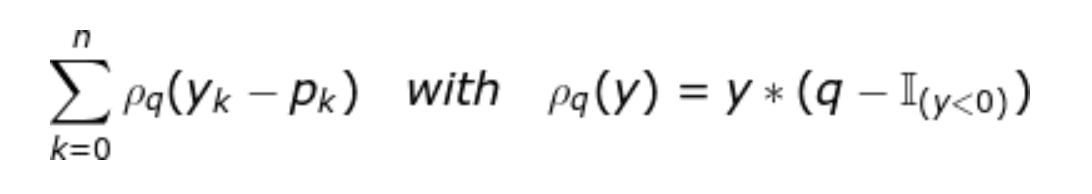

중요한 점은 핀볼 손실을 최소화한 모델이 최적의 Quantile을 출력한다는 점이다. 이 부분에 대해서는 좀더 공부를 할 필요가 있을 것 같다.

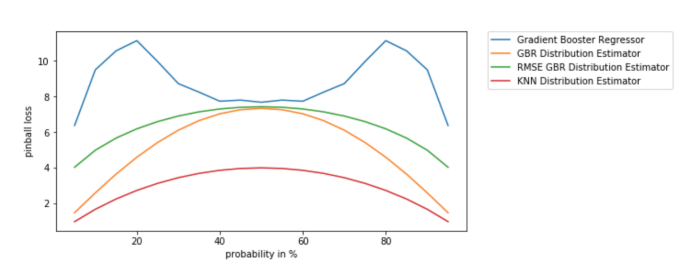

Distribution estimator(빨간색, 주황색 및 녹색 선)를 사용하는 모형은 다른 확률에 대해 단순 회귀 분석 모형(위의 그래프에서 파란색 선)보다 손실이 작다는 점에 주목할 필요가 있다. 훈련된 두 모델(한 모델에는 교육 데이터가 있고 다른 모델에는 오류가 있는 모델)을 사용하는 Distribution estimator 모델도 RMSE로 오차를 추정하는 모델보다 낫다.

### Conclusion
명백한 단순성과 가우스 가정에도 불구하고, Distribution estimator는 QR의 틀에서 효과적으로 사용될 수 있는 매우 강력한 도구라는 것이 증명됐다.

Gradient Boosted Quantile Regressor를 능가하는 것을 볼 수 있다.